# Insurance ML

predict risk of accidents

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
tf.random.set_seed(42)

In [3]:
import numpy as np
np.__version__

'1.21.6'

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [5]:
!pip install -q dtreeviz

     |████████████████████████████████| 61 kB 198 kB/s 


In [6]:
# https://github.com/parrt/dtreeviz
import dtreeviz
dtreeviz.__version__

'1.3.3'

In [7]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

     |████████████████████████████████| 71 kB 3.4 MB/s 


In [8]:
from lrcurve import KerasLearningCurve

In [9]:
from dtreeviz import clfviz

def plot_decision_boundaries(model, X, y_true, x1_range=None, x2_range=None):
  _, ax = plt.subplots(figsize=(8,4), dpi=300)


  ranges = None
  if x1_range and x2_range:
    ranges=(x1_range, x2_range)

  clfviz(
              model, X, y_true, 
             show=['instances', 'boundaries', 'probabilities', 'misclassified'],
             markers=['v', '^', 'd'],
             ntiles=50, 
             ax=ax,
            ranges=ranges,
             tile_fraction=1.0, 
             boundary_markersize=1.0,
             feature_names=["Age", "Max Speed"],
             colors={'class_boundary': 'black',
                     'tile_alpha': 0.5,
                    #  'warning' : 'yellow',
                     'classes':
                         [None,  # 0 classes
                          None,  # 1 class
                          None,  # 2 classes
                          ['#FF8080', '#FFFF80', '#8080FF'],  # 3 classes
                          ]
                     }
               )

# Step 1: Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. Risk is expressed as a number between 0 and 1. 1 meaning highest and 0 meaning lowerst risk of having an accident.

In [10]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/insurance-ml/main/data/insurance-customers-risk-1500.csv')

In [11]:
df.head()

,speed,age,miles,group,risk
0,97.0,44.0,30.0,1,0.597611
1,135.0,63.0,29.0,1,0.452710
2,111.0,26.0,34.0,0,0.750234
3,97.0,25.0,10.0,1,0.325249
4,114.0,38.0,22.0,2,0.269731


In [12]:
df.describe()

,speed,age,miles,group,risk
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.323333,44.989333,30.384000,0.999333,0.505887
std,17.417147,17.145297,15.214166,0.817177,0.256517
min,80.000000,16.000000,1.000000,0.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000,0.319750
50%,120.000000,42.000000,29.000000,1.000000,0.502173
75%,137.000000,54.000000,42.000000,2.000000,0.685074
max,166.000000,100.000000,84.000000,2.000000,1.000000


In [13]:
features = ['speed', 'age', 'miles']

In [14]:
import seaborn as sns

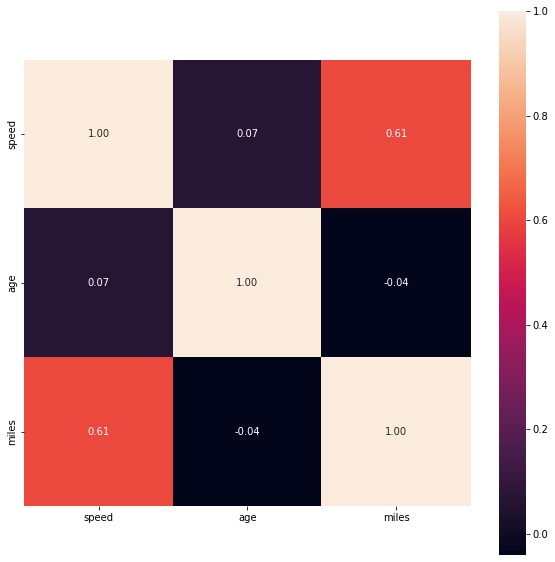

In [15]:
plt.figure(figsize=(10, 10))

cm = df.corr()
cm3 = cm.iloc[:3, :3]

hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                cmap='Blues', 
                fmt='.2f',
                yticklabels=features,
                xticklabels=features)

# Step 2: Training a neural network on 2 dimensions of the data

In [16]:
y = df['group'].values
# add more columns to list to have fewer features to train on
X = df.drop(['risk', 'group', 'miles'], axis='columns').values
# reorder, first age, then speed to match plotting
X = pd.DataFrame(np.array([X[:, 1], X[:, 0]]).T)
X.shape, y.shape

((1500, 2), (1500,))

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 2), (300, 2), (1200,), (300,))

In [18]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = X.shape[1]
dropout = 0.6
model = tf.keras.Sequential()

model.add(InputLayer(name='input', input_shape=(num_features,)))

model.add(Dense(500, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(500, name='hidden3'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 500)               1500      
                                                                 
 activation (Activation)     (None, 500)               0         
                                                                 
 batch_normalization (BatchN  (None, 500)              2000      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 hidden2 (Dense)             (None, 500)               250500    
                                                                 
 activation_1 (Activation)   (None, 500)               0         
                                                        

In [36]:
%%time 

BATCH_SIZE = 32
EPOCHS = 50

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 28.6 s, sys: 1.87 s, total: 30.5 s
Wall time: 21.9 s


In [37]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 [==============================] - 0s 3ms/step - loss: 0.7420 - accuracy: 0.6892


(0.7419580817222595, 0.6891666650772095)

In [38]:
test_loss, test_metric = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 6ms/step - loss: 0.7939 - accuracy: 0.6933


(0.7938867807388306, 0.6933333277702332)

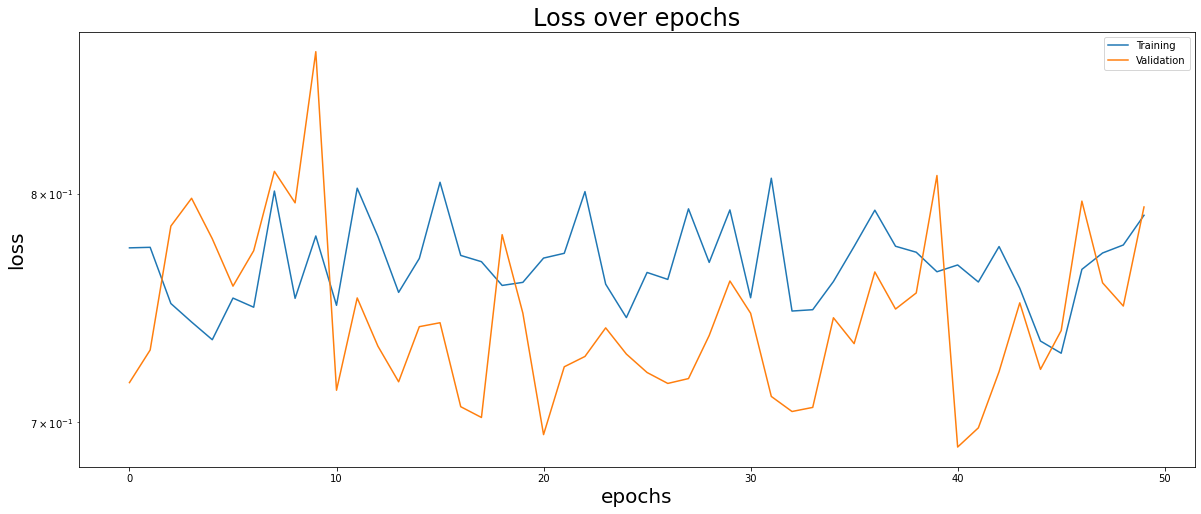

In [39]:
# XXX: those plots are happning all the time
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over epochs')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

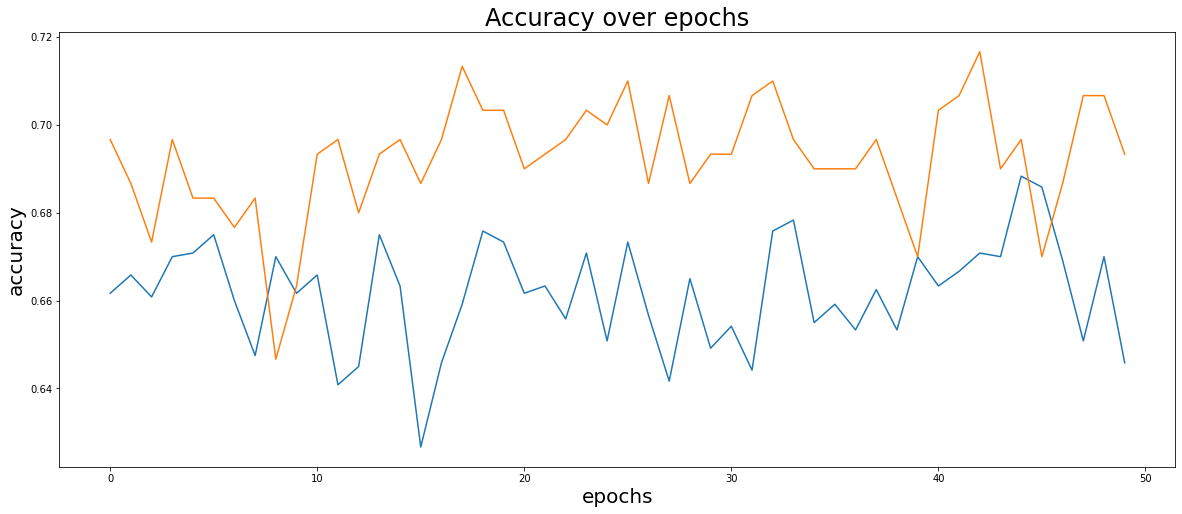

In [40]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [41]:
model.predict([[48, 100]])

array([[0.02604569, 0.16227596, 0.81167835]], dtype=float32)

In [42]:
model.predict([[48, 100]]).argmax()

2

In [43]:
model.predict([[30, 150]])

array([[0.93962246, 0.0376519 , 0.02272578]], dtype=float32)

In [44]:
model.predict([[30, 150]]).argmax()

0

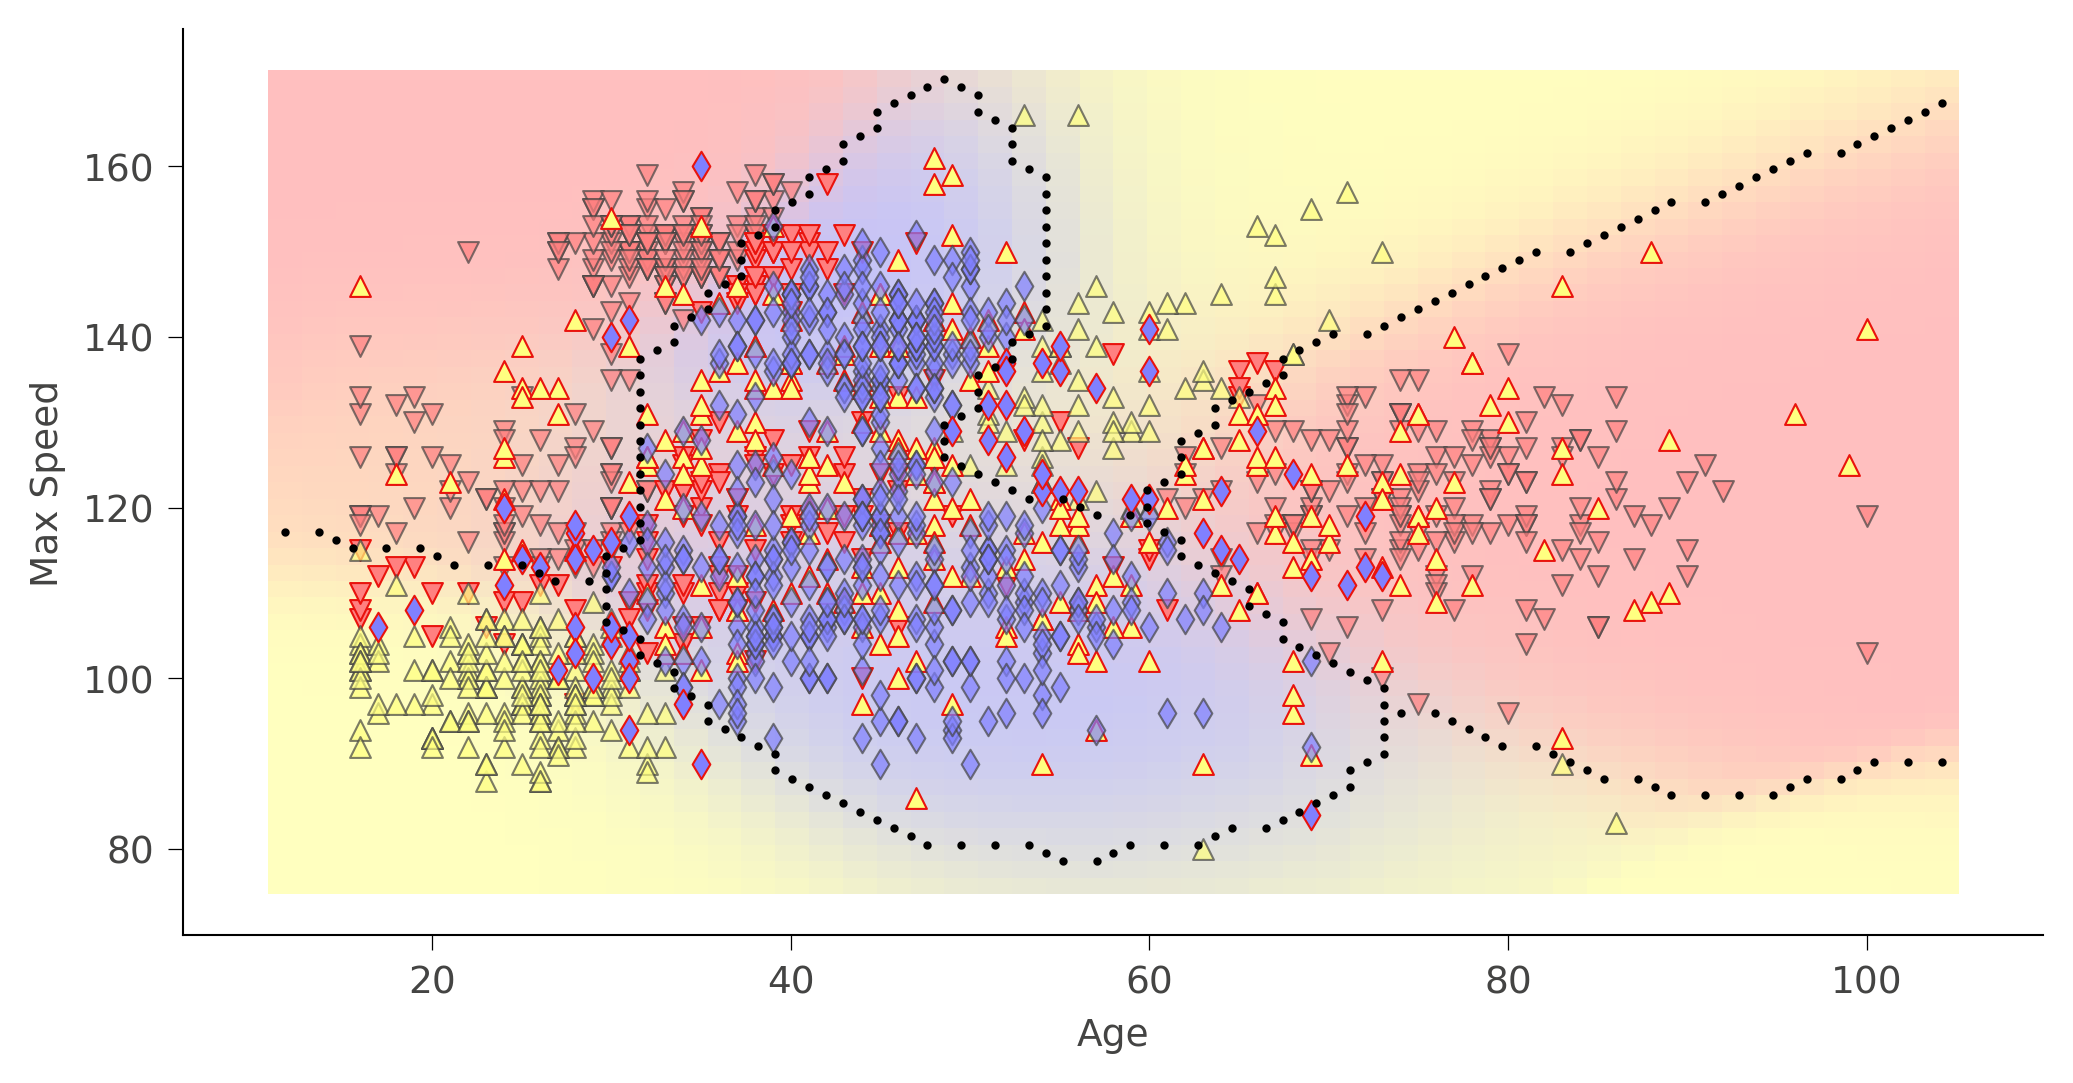

In [45]:
# plot_decision_boundaries(model, X, y, x1_range=(10, 150), x2_range=(50, 250))
plot_decision_boundaries(model, X, y)

In [46]:
# model.save?

In [47]:
model.save('classifier.h5', save_format='h5')

In [48]:
model.save('classifier', save_format='tf')

INFO:tensorflow:Assets written to: classifier/assets


In [49]:
!ls -l

total 11568
drwxr-xr-x 4 root root    4096 Jun 13 14:33 classifier
-rw-r--r-- 1 root root 6169904 Jun 13 14:32 classifier.h5
-rw-r--r-- 1 root root 5664259 Jun 13 14:31 classifier.tgz
drwxr-xr-x 1 root root    4096 Jun  1 13:50 sample_data


In [50]:
!ls -l classifier/

total 324
drwxr-xr-x 2 root root   4096 Jun 13 14:31 assets
-rw-r--r-- 1 root root  21458 Jun 13 14:33 keras_metadata.pb
-rw-r--r-- 1 root root 296576 Jun 13 14:33 saved_model.pb
drwxr-xr-x 2 root root   4096 Jun 13 14:33 variables


In [51]:
!tar czvf classifier.tgz ./classifier

./classifier/
./classifier/assets/
./classifier/saved_model.pb
./classifier/keras_metadata.pb
./classifier/variables/
./classifier/variables/variables.index
./classifier/variables/variables.data-00000-of-00001


In [35]:
!ls -l

total 11568
drwxr-xr-x 4 root root    4096 Jun 13 14:31 classifier
-rw-r--r-- 1 root root 6169904 Jun 13 14:31 classifier.h5
-rw-r--r-- 1 root root 5664259 Jun 13 14:31 classifier.tgz
drwxr-xr-x 1 root root    4096 Jun  1 13:50 sample_data
